Complete Guide to Anomaly Detection with AutoEncoders using Tensorflow

Loading Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['axes.grid'] = False

  About Dataset

In [10]:
!cat "/content/ECG5000_TRAIN.txt" "/content/ECG5000_TEST.txt" > ecg_final.txt
df = pd.read_csv("ecg_final.txt", sep='  ', header=None)
df.shape


<ipython-input-10-074b1302e8e0>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("ecg_final.txt", sep='  ', header=None)


(5000, 141)

In [11]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1.0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,...,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1.0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1.0,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1.0,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,1.0,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456


Basic Preprocessing

In [12]:
df = df.add_prefix('c')
df['c0'].value_counts()

1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: c0, dtype: int64

Train-Test Splitting and Scaling the data

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df.values, df.values[:,0:1], test_size=0.2, random_state=111)

In [14]:
scaler = MinMaxScaler()
data_scaled = scaler.fit(x_train)
train_data_scaled = data_scaled.transform(x_train)
test_data_scaled = data_scaled.transform(x_test)

Separate Anomaly and Normal Data

In [15]:
normal_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]
normal_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]

Data Visualization

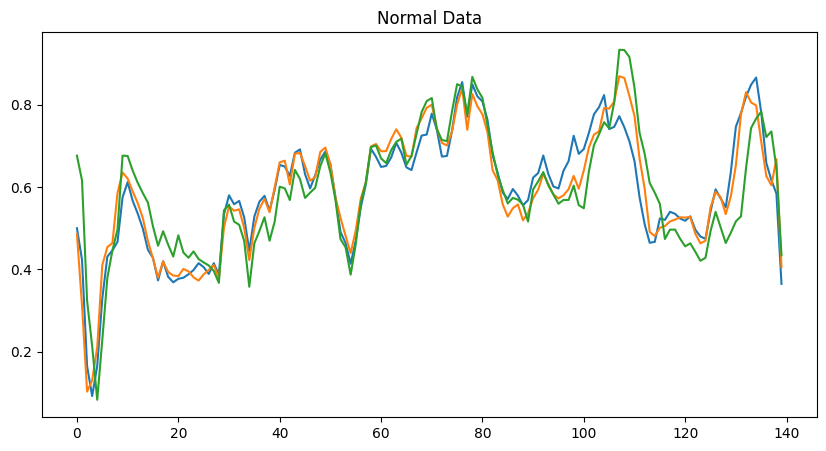

In [16]:
plt.plot(normal_train_data[0])
plt.plot(normal_train_data[1])
plt.plot(normal_train_data[2])
plt.title("Normal Data")
plt.show()

Anomaly Data

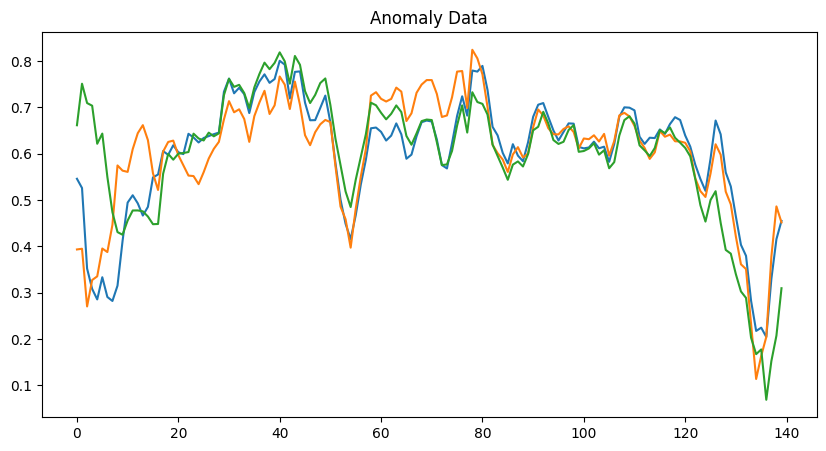

In [17]:
plt.plot(anomaly_train_data[0])
plt.plot(anomaly_train_data[1])
plt.plot(anomaly_train_data[2])
plt.title("Anomaly Data")
plt.show()

Modelling

In [18]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(140, activation="sigmoid"))

subclassing or Model subclassing

In [22]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(8, activation="relu")
              ])
    self.decoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(140, activation="sigmoid")
              ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

Compile and train the Model

In [24]:
model = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
model.compile(optimizer='adam', loss="mae")
history = model.fit(normal_train_data, normal_train_data, epochs=50, batch_size=120,
                    validation_data=(train_data_scaled[:,1:], train_data_scaled[:, 1:]),
                    shuffle=True,
                    callbacks=[early_stopping]
                    )

Epoch 1/50
20/20 [==============================] - 2s 29ms/step - loss: 0.1282 - val_loss: 0.1141
Epoch 2/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0791 - val_loss: 0.0815
Epoch 3/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0520 - val_loss: 0.0767
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0483 - val_loss: 0.0753
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0478 - val_loss: 0.0751
Epoch 6/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0476 - val_loss: 0.0743
Epoch 7/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0474 - val_loss: 0.0737
Epoch 8/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0470 - val_loss: 0.0731
Epoch 9/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0461 - val_loss: 0.0713
Epoch 10/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0427 - val_loss: 0.0661
Epoch 11/50
20/20 

Model Evaluation

In [26]:
encoder_out = model.encoder(normal_test_data).numpy() #8 unit representation of data
decoder_out = model.decoder(encoder_out).numpy()


First, we will plot the performance on Normal data which is first-class data.

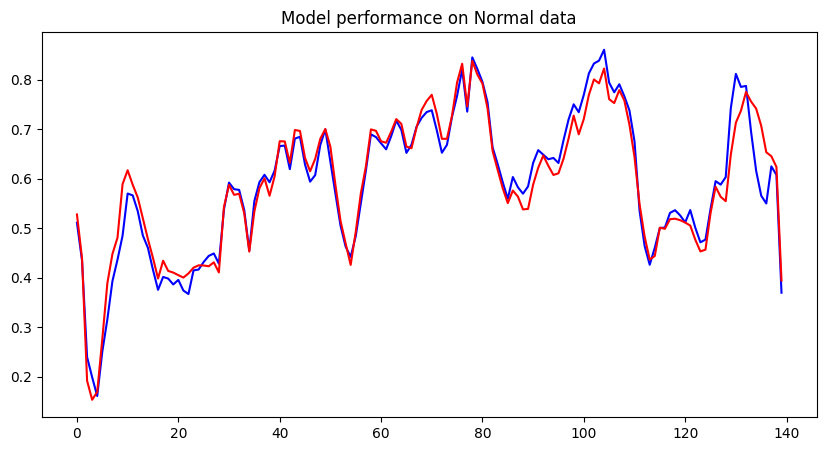

In [27]:
plt.plot(normal_test_data[0], 'b')
plt.plot(decoder_out[0], 'r')
plt.title("Model performance on Normal data")
plt.show()

In [28]:
encoder_out_a = model.encoder(anomaly_test_data).numpy() #8 unit representation of data
decoder_out_a = model.decoder(encoder_out_a).numpy()

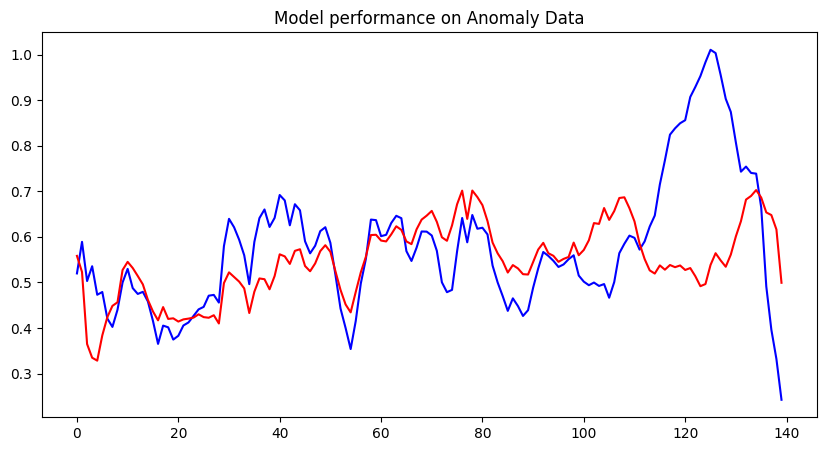

In [29]:
plt.plot(anomaly_test_data[0], 'b')
plt.plot(decoder_out_a[0], 'r')
plt.title("Model performance on Anomaly Data")
plt.show()

Calculate Loss

18/18 [==============================] - 0s 2ms/step


(array([ 7.,  8., 29., 27., 47., 37., 34., 34., 44., 33., 30., 22., 22.,
        20., 23., 13., 12., 13., 12., 10.,  4., 12.,  7.,  4., 11.,  5.,
         5.,  4.,  3.,  8.,  1.,  2.,  2.,  2.,  1.,  2.,  0.,  0.,  4.,
         1.,  1.,  1.,  1.,  3.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([0.01241947, 0.01420705, 0.01599463, 0.01778221, 0.0195698 ,
        0.02135738, 0.02314496, 0.02493254, 0.02672013, 0.02850771,
        0.03029529, 0.03208287, 0.03387046, 0.03565804, 0.03744562,
        0.0392332 , 0.04102079, 0.04280837, 0.04459595, 0.04638353,
        0.04817112, 0.0499587 , 0.05174628, 0.05353386, 0.05532145,
        0.05710903, 0.05889661, 0.06068419, 0.06247178, 0.06425936,
        0.06604694, 0.06783452, 0.0696221 , 0.07140969, 0.07319727,
        0.07498485, 0.07677243, 0.07856002, 0.0803476 , 0.08213518,
        0.08392276, 0.08571035, 0.08749793, 0.08928551, 0.09107309,
        0.09286068, 0.09464826, 0.09643584, 0.09822342, 0.10001101,
        0.10179859]),
 <BarContainer

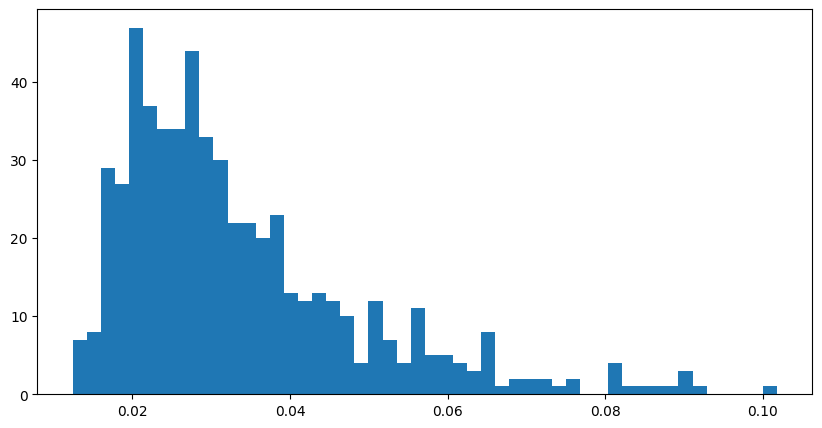

In [30]:
reconstruction = model.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstruction, normal_test_data)
plt.hist(train_loss, bins=50)

14/14 [==============================] - 0s 3ms/step


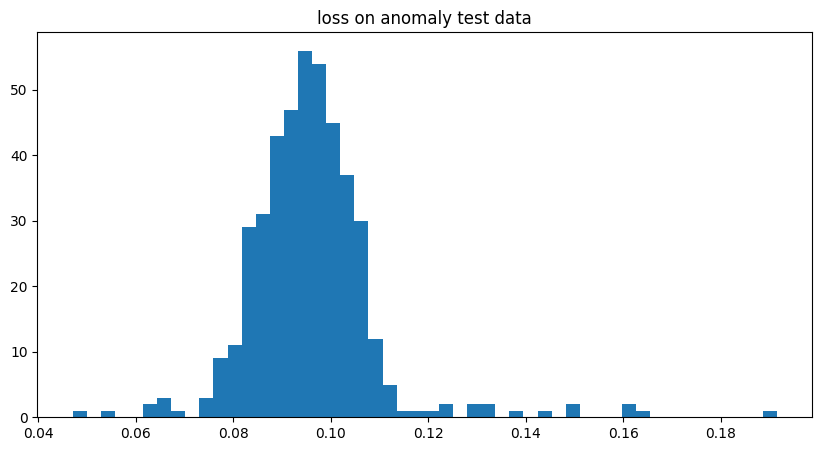

In [31]:
threshold = np.mean(train_loss) + 2*np.std(train_loss)
reconstruction_a = model.predict(anomaly_test_data)
train_loss_a = tf.keras.losses.mae(reconstruction_a, anomaly_test_data)
plt.hist(train_loss_a, bins=50)
plt.title("loss on anomaly test data")
plt.show()

Plot Normal and anomaly Loss together

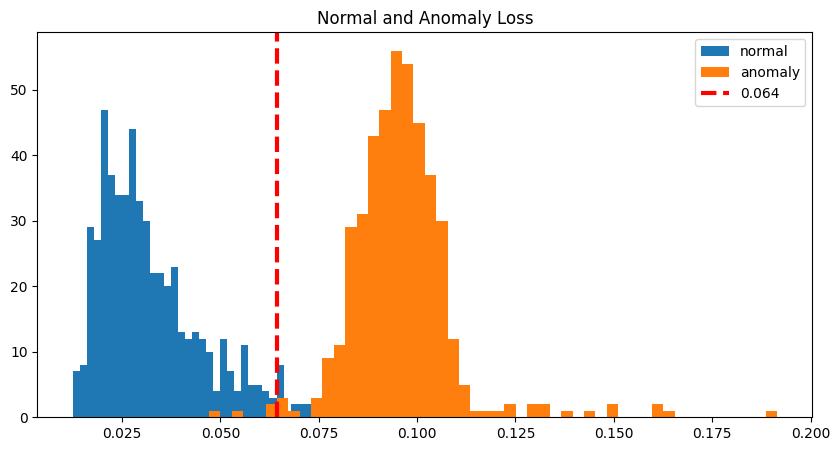

In [32]:
plt.hist(train_loss, bins=50, label='normal')
plt.hist(train_loss_a, bins=50, label='anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()